### Imports & Settings

In [1]:
from collections import Counter
import time
import numpy as np
import nn_model as nn
from utils import properties as p
from utils import get_rnd_ethnicity, get_rnd_gender
import hashlib
import matplotlib.pyplot as plt

In [2]:
from noknow.core import ZK, ZKSignature, ZKParameters, ZKData, ZKProof
import copy

### Parameters

In [3]:
epochs_n = 1
learning_rate = 0.1
seed = 19101995

features = {
    'ETHNICITY': ['Asian', 'Black', 'Indian', 'White'],
    'GENDER': ['Female', 'Male']
}

not_features = {
    'ETHNICITY': ['ROCK', 'PAPER', 'SCISSORS', 'UNCATEGORIZED'],
    'GENDER': ['ZERO', 'ONE']
}

### ZKP Server

In [4]:
class ZKServer:
    def __init__(self, password, features):
        self.password = password
        self.features = features
        self.client_representations = {}
        self.tokens = {}
        self.initialized_zk_features = False
        for el in features:
            self.client_representations[el] = []
            self.tokens[el] = []
        self.zk = ZK.new(curve_name="secp384r1", hash_alg="sha3_512")
        self.signature: ZKSignature = self.zk.create_signature(password)
            
    def load_client_signature(self, signature):
        #load client signature
        client_signature = ZKSignature.load(signature)
        return ZK(client_signature.params)
    
    def create_token(self, feature, signature):
        #load client signature
        client_signature = ZKSignature.load(signature)
        client_zk = ZK(client_signature.params)
        # Create a signed token and send to the client
        token = self.zk.sign(self.password, client_zk.token()).dump(separator=":")
        self.tokens[feature] += [token]
        self.client_representations[feature] += [{'signature' : client_signature, 'zk' : client_zk}]
        assert token in self.tokens[feature]
        return token
        
    def verify_clients(self, feature, signature):
        # Get the token from the client
        proof = ZKData.load(signature)
        token = ZKData.load(proof.data, ":")
        
        proofs = []
        # In this example, the server signs the token so it can be sure it has not been modified
        for label in self.client_representations[feature]:
            client_signature = label['signature']
            client_zk = label['zk']
            proofs += [self.verify_client(proof, token, client_signature, client_zk)]
            
        return sum(proofs) >= 1
    
    def verify_client(self, proof, token, client_signature, client_zk):
        return self.zk.verify(token, self.signature) and \
                client_zk.verify(proof, client_signature, data=token)
    
    def verify(self, feature, signatures):
        return sum([self.verify_clients(feature, s) for s in signatures]) >= 1
    
    def init_zk(self, clients):
        if self.initialized_zk_features:
            print('Server already initialized')
            return
        for c in clients:
            self.create_token(c.feature, c.signature)
        #print('Server initialized with ' + str(len(clients)) + ' features')
        self.initialized_zk_features = True

### ZKP Client

In [5]:
class ZKClient:
    def __init__(self, feature, label):
        self.zk = ZK.new(curve_name="secp256k1", hash_alg="sha3_256")
        self.label = label
        self.feature = feature
        # Create signature and send to server
        self.signature = self.zk.create_signature(label).dump()
        
    def set_label(self, label):
        self.label = label
        self.signature = self.zk.create_signature(label).dump()
            
    def create_proof(self, server_token):
        # Create a proof that signs the provided token and sends to server
        proof = self.zk.sign(self.label, server_token).dump()
        return proof
    
    def create_proofs(self, server_tokens):
        return [self.create_proof(t) for t in server_tokens]

### Server Initializer

In [6]:
class ServerInitializer:
    def __init__(self, features, client_prototype):
        self.client_prototype = client_prototype
        self.features = features
        
    def create_clients(self):
        clients = []
        for feature in self.features:
            for label in self.features[feature]:
                client = copy.copy(self.client_prototype)
                client.feature = feature
                client.set_label(label)
                clients += [client]
        return clients

### Client Initializer

In [7]:
class ClientInitializer:
    def __init__(self):
        self.generated = False
    def generate_client_prototype(self):
        if not self.generated:
            self.generated = True
            return ZKClient('', '')

### Model classes

In [8]:
#Server 
class FairServer(ZKServer):
    def __init__(self, password, features, model):
        super().__init__(password, features)
        self.model = LearningModel(model)
        self.workers = []
        self.groups = {}
        for f in self.features:
            self.groups[f] = Counter()
        
    def register_worker(self, worker):
        if self.zk_authenticate(worker):
            self.workers += [worker]
        
    def register_feature_group(self, feature, label):
        self.groups[feature].update({label : 1})

    def send_model(self, worker):
        worker.load_model(self.model)
        
    def load_weights(self, W):
        self.model.set_weights(W)
        
    def request_training(self, w):
        w.train()
        
    def zk_authenticate(self, w):
        #ZKP Authentication
        verification = [
            self.verify_clients(f, w.zkp_clients[f].create_proof(self.tokens[f][0]))
            for f in self.features                                    
        ]
        auth = sum(verification) == len(self.features)
        #print(('' if auth else 'Un') + 'authorized')
        return auth
    
    def train(self):
        for w in self.workers:
            self.send_model(w)
            self.request_training(w)
            
    def fair_metrics(self):
        return 'Fair metrics: '
    
    def predict(self, x):
        return self.model.predict(x)
    
    def plot_hist(self, feature):
        plt.title(feature)
        # density=False would make counts
        plt.hist(self.groups[feature], density=True, bins=len(self.groups[feature]) * 2 - 1)
        plt.ylabel('Probability')
        plt.xlabel('Data');
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False  # labels along the bottom edge are off
        ) 
        plt.show()

In [9]:
#Worker 
class Worker:
    #secret_features must of the form {'f_name_1': 'f_value_1', 'f_name_2': 'f_value_2', ...}
    def __init__(self, zkp_client_prototype, server, x, y, secret_features):
        self.zkp_client_prototype = zkp_client_prototype
        self.server = server
        self.model = {}
        self.x = x
        self.y = y
        self.secret_features = secret_features
        self.zkp_clients = {}
        for f in secret_features.keys():
            c = copy.copy(zkp_client_prototype)
            c.feature = f
            c.set_label(secret_features[f])
            self.zkp_clients[f] = c
        
    def send_registration(self):
        self.server.register_worker(self)
        
    def send_feature_group(self):
        for k in self.zkp_clients.keys():
            c = self.zkp_clients[k]
            #Create a secret hash
            secret = hashlib.sha256()
            #use the zk client salt value to encrypt the string
            encrypted_label = c.label + str(c.zk.params.s)
            #create the hash
            secret.update(encrypted_label.encode('utf-8'))
            self.server.register_feature_group(c.feature, secret.hexdigest())
                    
    def load_model(self, model):
        self.model = model
        
    def send_weights(self, W):
        self.server.load_weights(W)
        
    def train(self):
        self.model.train(self.x, self.y)
        self.send_weights(self.model.get_weights())
        self.send_feature_group()

In [10]:
class LearningModel:
    def __init__(self, model, epochs=epochs_n, learning_rate=learning_rate):
        self.model = model
        self.epochs = epochs
        self.learning_rate = learning_rate
    
    def set_weights(self, W):
        self.model.load_weights(W)
        
    def get_weights(self):
        return self.model.get_weights()
    
    def train(self, X, y):
        self.model.fit(X, y, self.epochs, self.learning_rate)
    
    def predict(self, x):
        return self.model.predict(x)

### ZKP-FED-Framework

In [11]:
class ZKPFEDFramework:
    def __init__(self, features, not_features, data=[]):
        self.client_prototype = ClientInitializer().generate_client_prototype()
        self.features = features
        self.not_features = not_features #TESTING
        self.server_initializer = ServerInitializer(features, self.client_prototype)

        self.test_server()
        
        
    #ZKP Assertions
    def test_server(self):
        #Create a mock server initializer with actual features
        si_f = ServerInitializer(self.features, self.client_prototype)
        
        #Create a mock server initializer with unauthorized features (not_features)
        si_n = ServerInitializer(self.not_features, self.client_prototype)
        
        #Create a mock server
        server = ZKServer('password', features)
        
        #Register authrized clients in the mock server
        server.init_zk(si_f.create_clients())
        
        #Create proofs for authorized users
        mock_clients_f = si_f.create_clients()
        proofs_f = [server.verify(c.feature, c.create_proofs(server.tokens[c.feature])) 
                  for c 
                  in mock_clients_f]
        
        #Create proofs for unauthorized users
        mock_clients_n = si_n.create_clients()
        proofs_n = [server.verify_clients(c.feature, c.create_proof(server.tokens[c.feature][0])) 
                  for c 
                  in mock_clients_n]
        
        #Assert that all the registered clients get access to the server
        assert sum(proofs_f) == len(mock_clients_f)
        
        #Assert that none of the non-registered clients get access to the server
        assert sum(proofs_n) == 0
        
    #Create a server
    def create_server(self, model):
        fs = FairServer('password', features, model)
        fs.init_zk(self.server_initializer.create_clients())
        return fs
    
    #Create workers
    def create_workers(self, server, X, y, secret_features):
        return [Worker(self.client_prototype, server, X[i], y[i], secret_features[i]) for i in range(len(X))]

    #Register all workers
    def register_workers(self, workers):
        for worker in workers:
            worker.send_registration()

    def start_training(self, server):
        start_train = time.time()
        server.train()
        end_train = time.time()
        #print('Training time:' + str(end_train - start_train))

    def zkp_fed_training(self, model, X, y, secret):
        s = self.create_server(model)
        ws = self.create_workers(s, X, y, secret)
        self.register_workers(ws)
        self.start_training(s)
        #print(s.fair_metrics())
        return s#, ws

### Model for reference

In [12]:
# network (not federated)
net = nn.get_3l_nn(2, 2, 1)

X = np.array([[[[0, 0]]], [[[0, 1]]], [[[1, 0]]], [[[1, 1]]]])
y = np.array([[[[0]]], [[[1]]], [[[1]]], [[[0]]]])

#train
for i in range(len(X)):
    net.fit(X[i], y[i], epochs=epochs_n, learning_rate=learning_rate)

# test
out = net.predict(X)

### Model for Fed-Learning

In [13]:
X = np.array([[[[0, 0]]], [[[0, 1]]], [[[1, 0]]], [[[1, 1]]], [[[1, 0]]]])
y = np.array([[[[0]]], [[[1]]], [[[1]]], [[[0]]], [[[1]]]])

zkp_fed_framework = ZKPFEDFramework(features, not_features)
# network (for federated learning)
net2 = nn.get_3l_nn(2, 2, 1)

#train
s = zkp_fed_framework.zkp_fed_training(net2, X, y, [
    {
        'ETHNICITY': get_rnd_ethnicity(),
        'GENDER': get_rnd_gender()
    } for _ in range(len(X) - 1)] + [
    {
        'ETHNICITY': 'unauthorized',
        'GENDER': get_rnd_gender()
    }
])

#test
out2 = s.predict([w.x for w in s.workers])

### Test if the 2 models behave in the same way

In [14]:
assert np.array_equal(out, out2)

### Test if workers retain feature [ethnicity]

In [15]:
def encode_sha256(s):
    secret = hashlib.sha256()
    secret.update(s.encode('utf-8'))
    return secret.hexdigest()

In [16]:
w_groups = [w.secret_features for w in s.workers] 
test_groups = {}

salt = zkp_fed_framework.client_prototype.zk.params.s

for f in features:
    test_groups[f] = Counter()
            
for t in w_groups:
    for f in t.keys():
        secret = t[f] + str(salt)
        secret = encode_sha256(secret)
        test_groups[f].update({secret : 1})
    
#check if the two counters are equal
assert test_groups == s.groups

### Plot data distribution

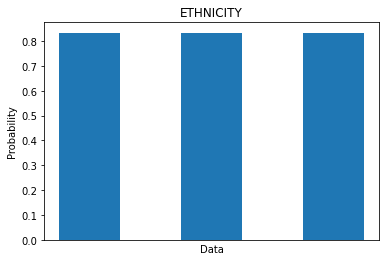

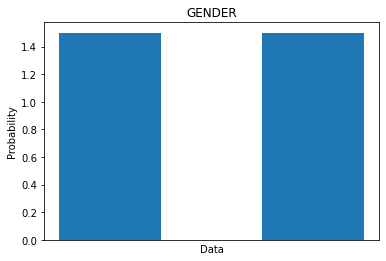

In [17]:
for f in features:    
    s.plot_hist(f)